**Table of contents**<a id='toc0_'></a>    
1.1. [Load Data](#toc1_1_)    
1.2. [Basic Summary Statistics](#toc1_2_)    
1.3. [Data Visualization](#toc1_3_)    
1.4. [Test on Proportion:$\mathcal{X}^2$ test (Chi-square test)](#toc1_4_)    
1.4.1.1. [One Proportion Test: 2 Categories](#toc1_4_1_1_)    
1.4.1.2. [$\mathcal{X}^2$ Test for 2 or more Categories](#toc1_4_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [17]:
import ipywidgets as widgets
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chisquare

# force reload modules
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.1. <a id='toc1_1_'></a>[Load Data](#toc0_)

In [18]:
df = pd.read_excel("data/data.xlsx", sheet_name='cat_univar')
df.head()

,Opinion
0,yes
1,yes
2,yes
3,yes
4,no


In [19]:
df.value_counts()

Opinion
no         71
yes        68
Name: count, dtype: int64

## 1.2. <a id='toc1_2_'></a>[Basic Summary Statistics](#toc0_)

In [20]:
data = df.copy()

In [21]:
X = data.values.flatten()
n = 50
X = np.random.choice(['yes', 'no'], size=n, p=[22/50, 28/50])
X = ['yes'] * 25 + ['no'] * 15 + ['idk'] * 5
X= np.array(X, dtype='object')

In [ ]:
summary_stats = pd.Series(X).describe()
summary_stats

count      45
unique      3
top       yes
freq       25
dtype: object

: 

## 1.3. <a id='toc1_3_'></a>[Data Visualization](#toc0_)

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.stattools import medcouple


def plot_univariate_cat(X, y_stats="proportion"):
    plt.figure(figsize=(5, 3))
    # plot conts values using plt
    sns.countplot(
        x=X,
        order=np.unique(X),
        palette="pastel",
        hue=X,
        edgecolor="black",
        stat=y_stats,
        width=0.5,
    )
    # set labels with counts
    counts = pd.Series(X).value_counts()
    labels = [f"{count} {label}" for label, count in counts.to_dict().items()]
    plt.xticks(ticks=np.arange(len(labels)), labels=labels)
    plt.title("Categorical Variable Distribution")
    plt.show()


widgets.interact(
    plot_univariate_cat,
    X=widgets.fixed(X),
    y_stats=widgets.Dropdown(
        options=["count", "proportion", "percent"], description="Stats:"
    ),
);

interactive(children=(Dropdown(description='Stats:', options=('count', 'proportion', 'percent'), value='count'…

## 1.4. <a id='toc1_4_'></a>[Test on Proportion:$\mathcal{X}^2$ test (Chi-square test)](#toc0_)

#### 1.4.1.1. <a id='toc1_4_1_1_'></a>[One Proportion Test: 2 Categories](#toc0_)

"""
Utility to recommend which test to use for a 1-sample proportion:
- Exact binomial test (`scipy.stats.binomtest`)
- Normal approximation z-test (`statsmodels.stats.proportion.proportions_ztest`)

Heuristics used:
1. If n is small  -> prefer binomtest
2. If expected counts (n * p0 or n * (1 - p0)) are small -> prefer binomtest
3. If hypothesized proportion p0 is very close to 0 or 1 (skewed) -> prefer binomtest
Otherwise -> z-test is fine.
"""

In [23]:
# get data parameters
observed = np.unique_counts(X).counts # Observed frequencies for all categories
count = observed.max()   # set dynamically Number of successes observed
n_cat = len(observed)
n = observed.sum()  # Total number of observations
p =  count / n # sample proportion
p0 = 1/n_cat # Hypothesized population proportion P0 = P

print(f"Number of successes observed: {count}")
print(f"Number of categories: {n_cat}")
print(f"Total number of observations: {n}")
print(f"Sample proportion: {p:.3f}")
print(f"Hypothesized population proportion: {p0:.3f}")

Number of successes observed: 25
Number of categories: 3
Total number of observations: 45
Sample proportion: 0.556
Hypothesized population proportion: 0.333


In [24]:
from collections import Counter

observed, Counter(X)

(array([ 5, 15, 25]), Counter({'yes': 25, 'no': 15, 'idk': 5}))

In [27]:
if n_cat == 2:
    # Perform the exact binomial test
    result = stats.binomtest(k=count, n=n, p=p0, alternative='two-sided')
    print(f"P-value: {result.pvalue:.4f}")
    print(f"Test statistic (proportion estimate): {result.statistic:.4f}")

    # Access the confidence interval
    ci = result.proportion_ci(confidence_level=0.95)
    print(f"95% Confidence Interval: [{ci.low:.2f}, {ci.high:.2f}]")

    # Interpretation:
    alpha = 0.05
    if result.pvalue < alpha:
        print(f"\tReject H0: The true proportion is significantly different from {p0:.2f}")
    else:
        print(f"\tFail to reject H0: No evidence that the true proportion differs from {p0:.2f}")
else:
    print("The test is not appropriate: variable is not binary")
    print("Use the chi-square test for more than 2 categories, followed by a post-hoc test")

The test is not appropriate: variable is not binary
Use the chi-square test for more than 2 categories, followed by a post-hoc test


In [25]:
from statsmodels.stats.proportion import proportions_ztest

if n_cat == 2:
    # Perform one-sample z-test for proportion
    stat, p_value = proportions_ztest(count=count, nobs=n, value=p0, alternative='two-sided')

    print(f"Successes: {count}")
    print(f"Total n: {n}")
    print(f"Hypothesized proportion p0 : {p0:.4f}")
    print(f"Z-statistic: {stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    # Simple interpretation at alpha = 0.05
    alpha = 0.05
    if p_value < alpha:
        print("\tReject H0: The true proportion is significantly different from p0")
    else:
        print("\tFail to reject H0: No evidence that the true proportion differs from p0")
else:
    print("The test is not appropriate: variable is not binary")
    print("Use the chi-square test for more than 2 categories, followed by a post-hoc test")

The test is not appropriate: variable is not binary
Use the chi-square test for more than 2 categories, followed by a post-hoc test


#### 1.4.1.2. <a id='toc1_4_1_2_'></a>[$\mathcal{X}^2$ Test for 2 or more Categories](#toc0_)

In [26]:
if n_cat >= 2:
	# Expected frequencies under H0: uniform distribution across n categories
	expected = np.array([n / n_cat] * n_cat)

	# Perform chi-square goodness-of-fit test
	chi2_stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected)

	print("Observed counts:", observed)
	print("Expected counts:", expected)
	print(f"Chi-square statistic: {chi2_stat:.2f}")
	print(f"p-value: {p_value:.4f}")

	# Optional: simple interpretation at alpha = 0.05
	alpha = 0.05
	if p_value < alpha:
		print(f"\tReject H0: The distribution is not uniform across the {n_cat} categories.")
	else:
		print(f"Fail to reject H0: No evidence against a uniform distribution across the {n_cat} categories.")

else:
    print("Chisquare test is inadapted")

Observed counts: [ 5 15 25]
Expected counts: [15. 15. 15.]
Chi-square statistic: 13.33
p-value: 0.0013
	Reject H0: The distribution is not uniform across the 3 categories.


* **Post-Hoc Analysis**: Pairewise chi-square propotion test

In [15]:
from collections import Counter
from itertools import combinations

if p_value < alpha:
    print("__________Need Post-Hoc Analysis___________")
    
    # Get counts
    counts = Counter(X)
    alpha = 0.05
    
    # Bonferroni correction
    n_comparisons = len(list(combinations(counts.keys(), 2)))
    # Bonferroni correction to account for multiple comparisons (optional but recommended)
    use_correction = True
    alpha_corrected = alpha / n_comparisons
    
    # Pairwise chi-square tests using combinations
    results = []
    for cat1, cat2 in combinations(counts.keys(), 2):
        obs = [counts[cat1], counts[cat2]]
        chi2, pval = chisquare(obs)
        results.append({
			'group1': cat1, 
			'group2': cat2, 
			'Chi2': chi2, 
			'p-value': pval, 
			'p-value_corrected': min(pval * n_comparisons, 1.0),
			'significant': pval < alpha_corrected if use_correction else pval < alpha
		})
    df_results = pd.DataFrame(results)
    print(f"Alpha: {alpha}, Bonferroni-corrected alpha: {alpha_corrected:.4f} (n_comparisons={n_comparisons})\n")
    display(df_results)
else:
    print("No need to do Post-Hoc Analysis because p-value is not significant")

__________Need Post-Hoc Analysis___________
Alpha: 0.05, Bonferroni-corrected alpha: 0.0167 (n_comparisons=3)



,group1,group2,Chi2,p-value,p-value_corrected,significant
0,yes,no,2.500000,0.113846,0.341539,False
1,yes,idk,13.333333,0.000261,0.000782,True
2,no,idk,5.000000,0.025347,0.076042,False


,group1,group2,chi2,p_value,p_value_display,significant
0,yes,no,2.5,0.113846,0.113846,False


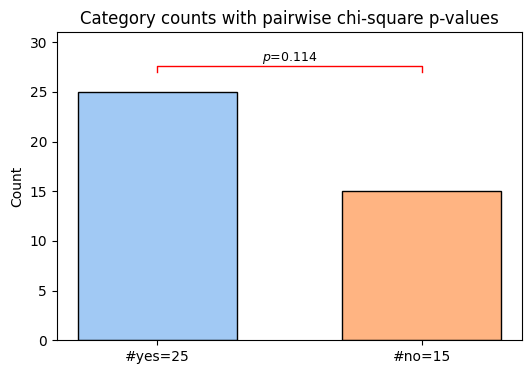

In [44]:

def plot_category_counts_with_pvalues(
    X,
    alpha=0.05,
    correction="bonferroni",
    ax=None,
    palette=None,
    title="Category counts with pairwise chi-square p-values",
):
    """Plot category counts and annotate pairwise chi-square p-values."""
    if isinstance(X, pd.Series):
        data = X.dropna()
    else:
        data = pd.Series(X).dropna()
    if data.empty:
        raise ValueError("Input data contains no non-missing values.")
    counts = data.value_counts()
    categories = counts.index.tolist()
    positions = list(range(len(categories)))
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    else:
        fig = ax.figure
    if palette is None:
        colors = sns.color_palette("pastel", len(categories))
    elif isinstance(palette, str):
        colors = sns.color_palette(palette, len(categories))
    else:
        colors = palette
    ax.bar(positions, counts.values, color=colors[: len(categories)], width=0.6, edgecolor="black")
    ax.set_xticks(positions)
    labels = [f"#{label}={count}" for label, count in counts.to_dict().items()]
    ax.set_xticks(ticks=np.arange(len(labels)), labels=labels)
    # ax.set_xticklabels(categories)
    ax.set_ylabel("Count")
    ax.set_title(title)
    from itertools import combinations
    combos = list(combinations(categories, 2))
    results = []
    if combos:
        n_comparisons = len(combos)
        y_max = counts.max()
        y_step = max(y_max * 0.08, 0.5)
        for idx, (cat1, cat2) in enumerate(combos):
            observed = counts.loc[[cat1, cat2]].values
            chi2, pval = chisquare(observed)
            if correction and correction.lower() == "bonferroni":
                pval_display = min(pval * n_comparisons, 1.0)
            else:
                pval_display = pval
            is_sig = pval_display < alpha
            results.append(
                {
                    "group1": cat1,
                    "group2": cat2,
                    "chi2": chi2,
                    "p_value": pval,
                    "p_value_display": pval_display,
                    "significant": is_sig,
                }
            )
            x1 = categories.index(cat1)
            x2 = categories.index(cat2)
            y = y_max + y_step * (idx + 1)
            ax.plot(
                [x1, x1, x2, x2],
                [y, y + y_step * 0.3, y + y_step * 0.3, y],
                color="green" if is_sig else "red",
                linewidth=1,
            )
            label = f"$p$={pval_display:.3f}"
            if is_sig:
                label += " *"
            ax.text(
                (x1 + x2) / 2,
                y + y_step * 0.3,
                label,
                ha="center",
                va="bottom",
                fontsize=9,
            )
        ax.set_ylim(0, y_max + y_step * (len(combos) + 2))
    else:
        ax.set_ylim(0, counts.max() * 1.1)
    df_results = pd.DataFrame(results)
    return fig, ax, df_results
fig, ax, posthoc = plot_category_counts_with_pvalues(X[X!='idk'], alpha=0.05)
display(posthoc)

